In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
class RLnetwork:
    def __init__(self, f, g, I_):
        self.f = f
        self.g = g
        self.I_ = np.array([I_, -I_, 0, 0])
        self.Wa = np.ones(9)
        self.Wc = np.ones(9)
        self.Gamma = np.eye(9, dtype=int)*9
        
        self.v = 1
        self.G = 100
        self.R = 1
        self.b = 1
        self.nc1 = 1
        self.nc2 = 1
        self.na1 = 5
        self.na2 = 1
        
        
    def equation(self, x, u):
        return self.f(x) + self.g(x) * u
    
    @staticmethod
    def sigma(x):
        return np.array([
            x[0]**2,
            x[0]*x[1],
            x[1]**2,
            np.sin(x[2]),
            np.sin(x[3]),
            np.cos(x[2]),
            np.cos(x[3]),
            np.sin(x[3]-x[2]),
            np.cos(x[3]-x[2])
        ])
    
    @staticmethod
    def grad_sigma(x):
        ds = np.empty((9,4))
        ds[0] = np.array([2*x[0], 0, 0, 0])
        ds[1] = np.array([x[1], x[0], 0, 0])
        ds[2] = np.array([0, 2*x[1], 0, 0])
        ds[3] = np.array([0, 0, np.cos(x[2]), 0])
        ds[4] = np.array([0, 0, 0, np.cos(x[3])])
        ds[5] = np.array([0, 0, -np.sin(x[2]), 0])
        ds[6] = np.array([0, 0, 0, -np.sin(x[3])])
        ds[7] = np.array([0, 0, -np.cos(x[3]-x[2]), np.cos(x[3]-x[2])])    
        ds[8] = np.array([0, 0, np.sin(x[3]-x[2]), -np.sin(x[3]-x[2])])
        return ds
    
    def sigmaG(self, x):
        gs = self.grad_sigma(x-self.I_)
        g = self.g(x)[:, None]
        return (1/self.R) * (gs @ g @ g.T @ gs.T) 
    
    def r(self, x, u):
        return (1/2)*(x[0])**2 + self.R*(u**2)
    
    def V(self, x):
        return self.Wc @ self.sigma(x-self.I_)
    
    def u(self, x):
        gs = self.grad_sigma(x-self.I_)
        return - (1/2) * (1/self.R) * (self.g(x)@ (gs.T @ self.Wa))
    
    def delta(self, x):
        u = self.u(x)
        return (self.Wc[:, None].T @ self.grad_sigma(x-self.I_)) @ self.equation(x, u) + self.r(x-self.I_, u)
    
    @staticmethod
    def generate_x(x, N=10):
        perturbation = np.random.uniform(-1, 1, N)
        x_set = np.vstack([perturbation, -perturbation, np.zeros((2, N))]).T + x
        return x_set
    
    
    def w(self, x):
        xdot = self.equation(x, self.u(x))
        gs = self.grad_sigma(x-self.I_)
        return gs@xdot
    
    def p(self, w):
        return 1 + self.v * (w[:, None].T @ self.Gamma @ w)
    
    def upd_Wc(self, x, x_set, dt=0.1):
        w = self.w(x)
        w1 = -self.nc1*self.delta(x)* (self.Gamma @ w) / self.p(w)
        
        si = []
        for xi in x_set:
            _wi = self.w(xi)
            _pi = self.p(_wi)
            _deltai = self.delta(xi)
            si.append(_deltai*_wi/_pi)
        s = np.sum(si, axis=0)/len(x_set)
        w2 = -self.nc2* (self.Gamma @ s)
        
        self.Wc = self.Wc + (w1+w2)*dt
        
    def upd_Gamma(self, x, dt=0.1):
        w = self.w(x)
        p = self.p(w)
        g = - self.nc1*(self.Gamma@w[:,None])@(w[:,None].T@self.Gamma)/(p**2)
        
        gamma = self.b*self.Gamma + g
        self.Gamma = gamma*(np.linalg.norm(gamma)<self.G)
        
    def upd_Wa(self, x, x_set, dt=0.1):
        w = self.w(x)
        p = self.p(w)
        sigmaG = self.sigmaG(x)
        
        w1 = - self.na1 * (self.Wa - self.Wc)
        
        w2 = - self.na2 * self.Wa
        
        w3 = (self.nc1/(4*p)) * (sigmaG.T @ self.Wa[:, None] @ w[:, None].T @ self.Wc)
        
        si = []
        for xi in x_set:
            _wi = self.w(xi)
            _pi = self.p(_wi)
            _sigmaGi = self.sigmaG(xi)
            si.append((_sigmaGi.T @ self.Wa[:, None] @ _wi[:, None].T)/_pi)
        s = np.sum(si, axis=0)/len(x_set)
        w4 = (self.nc2/4) *(s @ self.Wc)
        
        self.Wa = self.Wa + (w1+w2+w3+w4)*dt
    
    def optimize(self, x):
        x_set = self.generate_x(x)
        
        self.upd_Gamma(x)
        self.upd_Wc(x, x_set)
        self.upd_Wa(x, x_set)
        return self.u(x)
        

In [90]:
from models import Model1

In [91]:
m1 = Model1(np.array([6, 4, 0, 0]))
net = RLnetwork(m1.f, m1.g, 8)
u = net.u(m1.state)
u

-0.0

In [92]:
for i in range(990):
    m1.update(u)
    u = net.optimize(m1.state)
    print(u) if i%100==0 else _

-1.2238734621345713
-0.0036803526050801505
0.034638352430433894
-0.017240398759278186
-0.019485394289792346
-0.0032785262044550123
0.01281501891278447
-0.015745640684194928
-0.00020695565048711728
0.015734351542578295


In [93]:
m1.state

array([   8.02973692,    1.97026308, 1664.43853008, 1500.6167723 ])

<module 'matplotlib.pyplot' from 'C:\\Users\\manyasha_n_m\\Desktop\\FI81\\4\\diploma\\env\\lib\\site-packages\\matplotlib\\pyplot.py'>

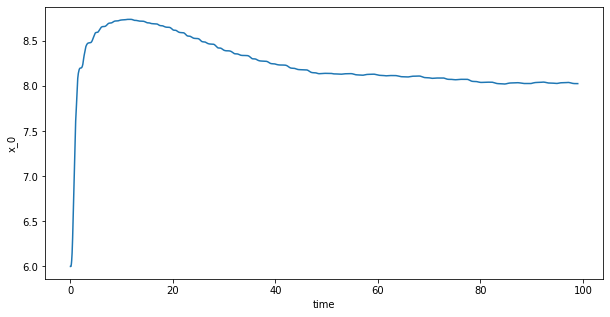

In [94]:
m1.plot_evolution(0)

<module 'matplotlib.pyplot' from 'C:\\Users\\manyasha_n_m\\Desktop\\FI81\\4\\diploma\\env\\lib\\site-packages\\matplotlib\\pyplot.py'>

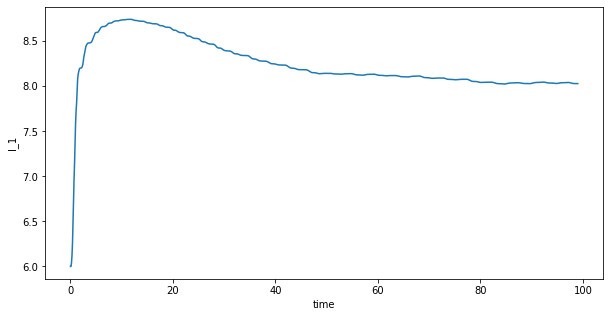

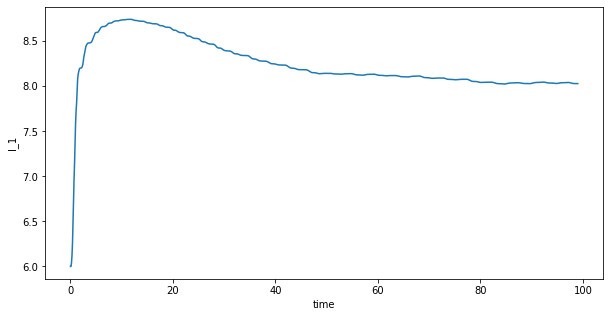

In [97]:
m1.plot_measurable

In [95]:
net.Wc.round(2), net.Wa.round(2)

(array([ 0.97,  1.21,  0.6 ,  0.  , -0.  ,  0.01,  0.  ,  0.5 ,  0.48]),
 array([ 0.81,  1.01,  0.5 , -0.  , -0.  ,  0.  ,  0.  ,  0.42,  0.4 ]))

In [96]:
net.Gamma.round(2)

array([[ 9.  ,  0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,  0.  ,  0.  ],
       [ 0.  ,  9.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.  ],
       [-0.  ,  0.  ,  8.99, -0.  , -0.  , -0.  , -0.  ,  0.  , -0.  ],
       [-0.  ,  0.  , -0.  ,  8.48, -0.01, -0.  ,  0.  ,  0.  ,  0.  ],
       [-0.  ,  0.  , -0.  , -0.01,  8.58, -0.  , -0.  ,  0.  , -0.  ],
       [-0.  ,  0.  , -0.  , -0.  , -0.  ,  8.48, -0.01,  0.  , -0.  ],
       [-0.  ,  0.  , -0.  ,  0.  , -0.  , -0.01,  8.58,  0.  ,  0.  ],
       [ 0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  8.99,  0.  ],
       [ 0.  ,  0.  , -0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  ,  8.99]])

<module 'matplotlib.pyplot' from 'C:\\Users\\manyasha_n_m\\Desktop\\FI81\\4\\diploma\\env\\lib\\site-packages\\matplotlib\\pyplot.py'>

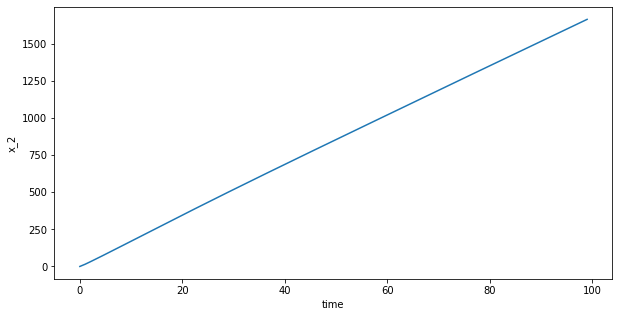

In [99]:
m1.plot_evolution(2)